## In this notebook we compute popular maesure Risks such as Value at Risk(VaR) and Conditional VaR(CVaR), using historical stock data, parametric fitting and finally Monte Carlo Simulations. We extract stock data using the yfinance package.

## The goal is to show that the t distribution captures tail risk much better than the normal distribution

In [ ]:
import pandas as pd
import yfinance as yf
import time

tickers = ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AMZN']
start_date = '2020-01-01'
end_date = '2024-06-01'

adj_close_data = {}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    t = yf.Ticker(ticker)
    df = t.history(start=start_date, end=end_date)
    adj_close_data[ticker] = df['Close']  # or 'Adj Close' if available
    time.sleep(0.5)  # optional delay

# Combine into dataframe
data = pd.DataFrame(adj_close_data)
print(data.head())


In [2]:
data.tail()

,AAPL,MSFT,GOOG,NVDA,AMZN
Date,,,,,
2024-05-24 00:00:00-04:00,189.095657,426.887085,175.288071,106.426643,180.750000
2024-05-28 00:00:00-04:00,189.105621,427.045868,176.968063,113.855682,182.149994
2024-05-29 00:00:00-04:00,189.404205,425.904633,176.351730,114.779305,182.020004
2024-05-30 00:00:00-04:00,190.399567,411.514923,172.534424,110.456024,179.320007
2024-05-31 00:00:00-04:00,191.355103,411.971436,172.932068,109.589378,176.440002


In [20]:
data.shape

(1111, 5)

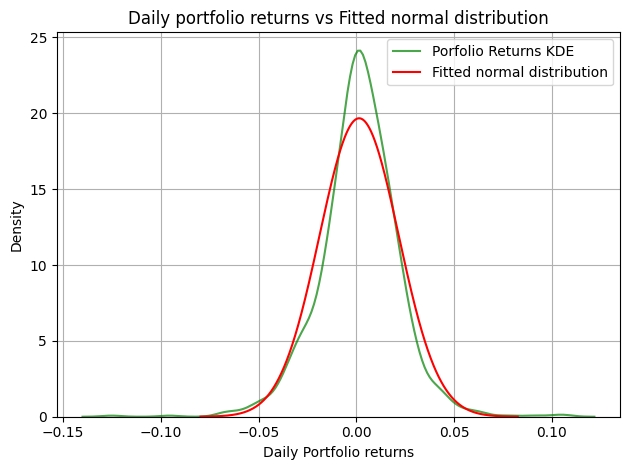

In [33]:
import seaborn as sns
sns.kdeplot(portfolio_returns, color='green', fill=False, alpha=0.7, label='Porfolio Returns KDE')
from scipy.stats import norm
x=np.linspace(mean-4*std_dev,mean+4*std_dev,1000)
plt.plot(x,norm.pdf(x, mean, std_dev),'r-', label='Fitted normal distribution')
plt.title('Daily portfolio returns vs Fitted normal distribution')
plt.xlabel('Daily Portfolio returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Though it seems like a decent fit, normal distributions are bad at capturing tail risks.

=== Portfolio Risk Metrics with Normal distribution (95% confidence) ===
Historical VaR: -0.0316
Parametric VaR: -0.0319
Monte Carlo VaR: -0.0319
Conditional VaR (CVaR): -0.0452


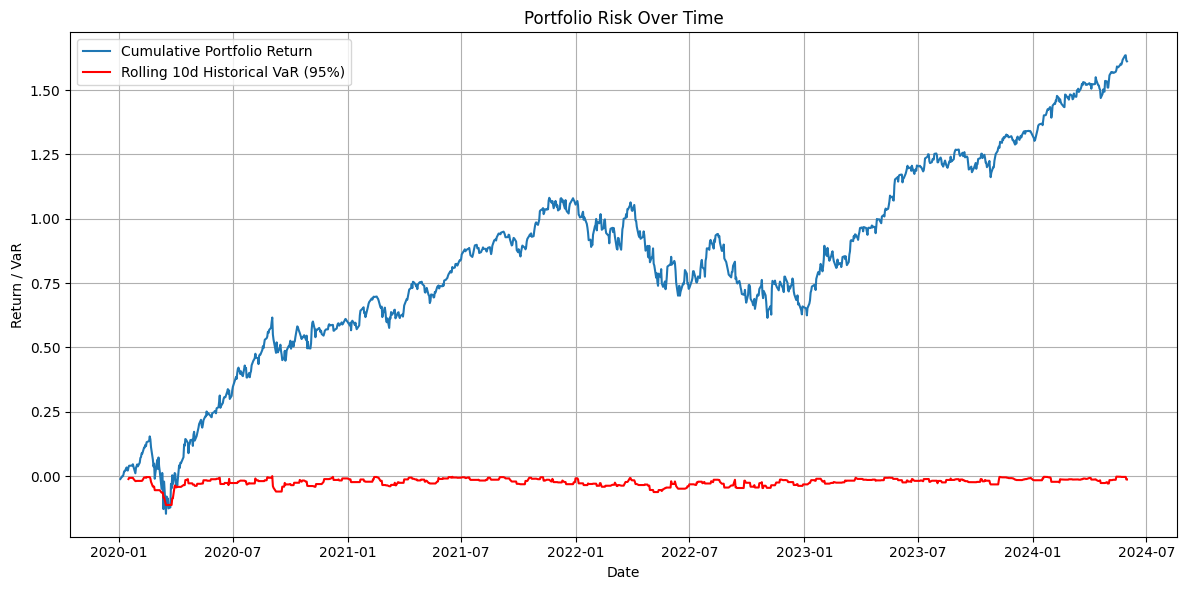

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
#  Calculate daily returns 
returns = data.pct_change().dropna()

# Portfolio weights (equal weights as example)
weights = np.array([1/len(tickers)] * len(tickers))

# Portfolio daily returns -
portfolio_returns = returns.dot(weights)

confidence_level=0.95
#  Historical VaR 
hist_VaR = np.percentile(portfolio_returns, (1-confidence_level)*100) #Note: Historical VaR doesnt depend on the distribution

#  Parametric VaR (Variance-Covariance, assuming normality) 
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()
param_VaR = stats.norm.ppf(1 - confidence_level, mean, std_dev)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = np.random.normal(mean, std_dev, n_simulations)
mc_VaR = np.percentile(simulated_returns, (1-confidence_level)*100)

#  Conditional VaR (CVaR) 
CVaR = portfolio_returns[portfolio_returns <= hist_VaR].mean()

# Print results
print(f"=== Portfolio Risk Metrics with Normal distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"Historical VaR: {hist_VaR:.4f}")
print(f"Parametric VaR: {param_VaR:.4f}")
print(f"Monte Carlo VaR: {mc_VaR:.4f}")
print(f"Conditional VaR (CVaR): {CVaR:.4f}")

# Visualization: rolling historical VaR over time 
window = 10  # 60-day rolling window
rolling_VaR = portfolio_returns.rolling(window).apply(
    lambda x: np.percentile(x, (1-confidence_level)*100), raw=False
)

plt.figure(figsize=(12,6))
plt.plot(portfolio_returns.index, portfolio_returns.cumsum(), label='Cumulative Portfolio Return')
plt.plot(rolling_VaR, label=f'Rolling {window}d Historical VaR ({confidence_level*100:.0f}%)', color='red')
plt.title('Portfolio Risk Over Time')
plt.xlabel('Date')
plt.ylabel('Return / VaR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
returns.min()

AAPL   -0.128647
MSFT   -0.147390
GOOG   -0.111008
NVDA   -0.184521
AMZN   -0.140494
dtype: float64

In [34]:
from scipy.stats import shapiro
stat, p_value = shapiro(portfolio_returns)
print(f"Shapiro-Wilk p-value: {p_value:.4f}")


Shapiro-Wilk p-value: 0.0000


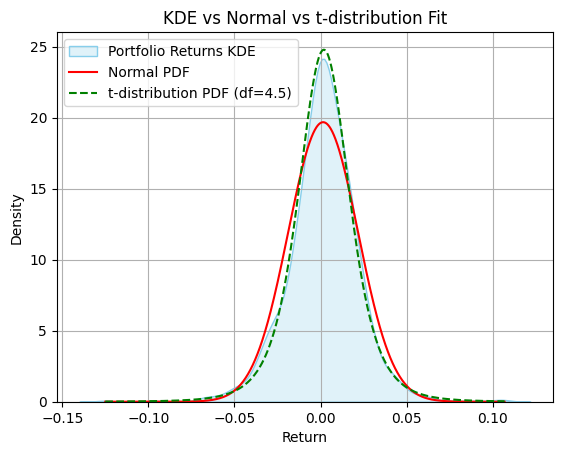

In [35]:
from scipy.stats import t

# Fit a t-distribution to portfolio returns
df, loc, scale = t.fit(portfolio_returns)

# Compare fit with KDE and normal
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)

sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio Returns KDE')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'r-', label='Normal PDF')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')

plt.title("KDE vs Normal vs t-distribution Fit")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


## The t-distribution is a much better fit the stock prices! Lets recompute everything(except Historical VaR)

In [ ]:
#  Parametric VaR (Variance-Covariance, assuming normality) 
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()
param_VaR_t = stats.t.ppf(1 - confidence_level, df, mean, std_dev)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = mean + std_dev * np.random.standard_t(df, size=n_simulations)
mc_VaR_t = np.percentile(simulated_returns, (1-confidence_level)*100)

t_CVaR = simulated_returns[simulated_returns <= mc_VaR_t].mean()

# Print results
print(f"=== Portfolio Risk Metrics with t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"Parametric VaR_t: {param_VaR_t:.4f}")
print(f"Monte Carlo VaR_t: {mc_VaR_t:.4f}")
print(f"Monte Carlo CVaR (95%): {t_CVaR:.4f}")


=== Portfolio Risk Metrics with t-distribution (95% confidence) ===
Parametric VaR_t: -0.0405
Monte Carlo VaR_t: -0.0404
Monte Carlo CVaR (95%): -0.0625


## The VaR values are now higher, as we have captured more tail risk with the t distribution now

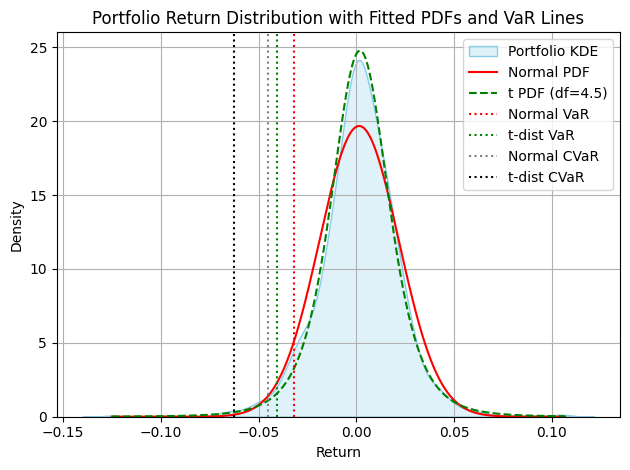

In [55]:
# Dashboard plot
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio KDE')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'r-', label='Normal PDF')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't PDF (df={df:.1f})')

# VaR lines
plt.axvline(param_VaR, color='red', linestyle=':', label='Normal VaR')
plt.axvline(param_VaR_t, color='green', linestyle=':', label='t-dist VaR')
plt.axvline(CVaR,color='grey', linestyle=':', label = 'Normal CVaR')
plt.axvline(t_CVaR,color='black', linestyle=':', label = 't-dist CVaR')

plt.title('Portfolio Return Distribution with Fitted PDFs and VaR Lines')
plt.xlabel('Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## The summary of obtained results is plotted above. We clearly see that the t-distribution fits the stock data much better,and captures tail risk much better, which the normal distribution underestimates